## <u>Notebook Synopsis:</u> In the previous notebook, I created a number of data sets from the larger nomad data set pre-processed 2 notebooks prior. In this notebook I load the subset intended for this project

In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
#import pymc3 as pm

#import arviz as ar
import matplotlib.pyplot as pl
from matplotlib import rcParams
#import seaborn as sb
%matplotlib inline

In [3]:
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

## Methods

The dataset used in this study was generated from the NOMAD dataset. 6 Rrs bands were used at 6 wavelength corresponding to SeaWiFS spectral coverage; 412, 443, 490, 510, 555, 670 nm. Of these, only 443 - 555 nm bands were retained. In this notebook, the following data transformation/feature engineering steps are implemented:

* for band ratio algorithms, relevant ratios are pre-computed;
* for band ratio algorithms with max(Blue) formulation, blue band used in the ratio is identified and flagged for grouping in partially pooled models
* reflectances, reflectance ratios and chlorophyll are log-transformed;
* for PCA-based algorithms, principal components were computed for all bands.
* chlorophyll measurement method (hplc or not) zasu7ZL/.%T'            s identified and flagged
* all predictors are standardized for more efficient 

In [8]:
df_ = pd.read_pickle('./pickleJar/df_nopurple_nored.pkl')

### Compute band ratios, along with blue band used in the ratio, and an integer index to the same for use in partial pooling models:

In [9]:
def insert_MBR(df_):
    insert_loc = df_.columns.get_loc('chlor_a')
    blue_cols = ['rrs443', 'rrs489', 'rrs510']
    df_.insert(insert_loc, 'MaxBlue', df_[blue_cols].max(axis=1))
    insert_loc += 1
    df_.insert(insert_loc, 'MaxBlueBand', df_[blue_cols].idxmax(axis=1).str.capitalize())
    insert_loc += 1
    df_.insert(insert_loc,'MaxBlueBandIdx',
               pd.Categorical(df_.MaxBlueBand, categories=[bluecol.capitalize() for bluecol in blue_cols]).codes)
    insert_loc += 1
    df_.insert(insert_loc, 'mxBlue2Gr', df_.MaxBlue / df_.rrs555)

In [ ]:
insert_MBR(df_)

In [10]:
df_.head()

,id,rrs443,rrs489,rrs510,rrs555,MaxBlue,MaxBlueBand,MaxBlueBandIdx,mxBlue2Gr,chlor_a,is_hplc
0,1565,0.001686,0.003293,0.004036,0.007479,0.004036,Rrs510,2,0.539676,38.19,False
1,1566,0.001384,0.002173,0.002499,0.004152,0.002499,Rrs510,2,0.601926,35.01,False
2,1567,0.001185,0.001843,0.002288,0.004246,0.002288,Rrs510,2,0.538844,26.91,False
3,1568,0.001741,0.002877,0.003664,0.006982,0.003664,Rrs510,2,0.524837,47.96,False
4,1559,0.001022,0.001506,0.001903,0.002801,0.001903,Rrs510,2,0.679622,23.55,False


In [11]:
df_.to_pickle('./pickleJar/df_nopurple_nored_with_MBR.pkl')

### Log-transforming reflectances, ratios, and chlor_a

In [16]:
def log_transform_for_chl_model(df_):
    columns_to_log_transform = df_.filter(regex='(rrs|chl|mxBlue2)',
                                             axis=1).columns.tolist()
    # log_transforms
    df_log = pd.DataFrame(np.log10(df_.loc[:,
                                           columns_to_log_transform
                                          ].values),
                          columns=[f'log_{col}' 
                                   for col in columns_to_log_transform])
    return df_log

Note on computing sd on log scale:


If Var(exp(log_rrs))≈exp$(\mu_{log\_rrs})^2\sigma^2_{log\_rrs}$

$sd(exp(log\_rrs))≈exp(\mu_{log\_rrs})\sigma_{log\_rrs}$


$\leftrightarrow \ \sigma_{log\_rrs} ≈ \frac{sd(rrs)}{exp(\mu_{log\_rrs})}$

In [17]:
df_log.head()

,log_rrs443,log_rrs489,log_rrs510,log_rrs555,log_mxBlue2Gr,log_chlor_a
0,-2.773122,-2.482397,-2.394012,-2.126145,-0.267867,1.581950
1,-2.858857,-2.662956,-2.602191,-2.381734,-0.220457,1.544192
2,-2.926105,-2.734427,-2.640597,-2.372060,-0.268537,1.429914
3,-2.759143,-2.541014,-2.436014,-2.156039,-0.279976,1.680879
4,-2.990409,-2.822196,-2.720468,-2.552735,-0.167733,1.371991


In [18]:
df_log.insert(0, 'id', df_.id)
df_log.insert(df_log.columns.get_loc('log_mxBlue2Gr'), 
             'MaxBlueBand', df_.MaxBlueBand)
df_log.insert(df_log.columns.get_loc('MaxBlueBand')+1, 'MaxBlueBandIdx', df_.MaxBlueBandIdx)
df_log['is_hplc'] = df_.is_hplc

df_log = df_log[['id', 'log_rrs443', 'log_rrs489', 'log_rrs510', 'log_rrs555',
                 'MaxBlueBand', 'MaxBlueBandIdx', 'log_mxBlue2Gr', 'log_chlor_a', 'is_hplc']]

df_log.head()

,id,log_rrs443,log_rrs489,log_rrs510,log_rrs555,MaxBlueBand,MaxBlueBandIdx,log_mxBlue2Gr,log_chlor_a,is_hplc
0,1565,-2.773122,-2.482397,-2.394012,-2.126145,Rrs510,2,-0.267867,1.581950,False
1,1566,-2.858857,-2.662956,-2.602191,-2.381734,Rrs510,2,-0.220457,1.544192,False
2,1567,-2.926105,-2.734427,-2.640597,-2.372060,Rrs510,2,-0.268537,1.429914,False
3,1568,-2.759143,-2.541014,-2.436014,-2.156039,Rrs510,2,-0.279976,1.680879,False
4,1559,-2.990409,-2.822196,-2.720468,-2.552735,Rrs510,2,-0.167733,1.371991,False


In [19]:
df_log.describe()

,id,log_rrs443,log_rrs489,log_rrs510,log_rrs555,MaxBlueBandIdx,log_mxBlue2Gr,log_chlor_a
count,4459.000000,4456.000000,4422.000000,3435.000000,3255.000000,4459.000000,3255.000000,4127.000000
mean,4377.381251,-2.421040,-2.395443,-2.447466,-2.611693,0.843014,0.278669,-0.112459
std,2298.272102,0.292499,0.224659,0.220647,0.292241,0.802378,0.310451,0.687956
min,6.000000,-3.721171,-3.546531,-3.583095,-3.737064,0.000000,-0.398402,-1.920819
25%,2028.500000,-2.582159,-2.515600,-2.548050,-2.799234,0.000000,0.020759,-0.632039
50%,5039.000000,-2.409061,-2.381635,-2.465355,-2.683803,1.000000,0.228030,-0.116907
75%,6271.500000,-2.216361,-2.247581,-2.372431,-2.502876,2.000000,0.534595,0.332438
max,7831.000000,-1.434521,-1.195083,-1.109354,-1.331613,2.000000,1.010287,1.891341


In [20]:
df_log.to_pickle('./pickleJar/df_log_nopurple_nored_with_MBR.pkl')

### Computing Principal Components

In [21]:
#Compute PC for all bands, for PCA-based regression algorithms
pc_transformer = PCA()
PCs = pc_transformer.fit_transform(df_log.filter(regex='rrs',
                                                 axis=1).dropna()
                                  )
df_pc = pd.DataFrame(PCs, columns = [f'pc{i+1}' 
                                     for i in range(PCs.shape[1])])

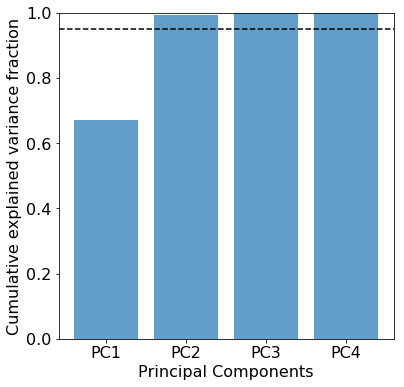

In [22]:
# Plotting explained variance of principle components
_, ax = pl.subplots(figsize=(6, 6))
ax.bar([f'PC{i}' for i in range(1, 5)],
       np.cumsum(pc_transformer.explained_variance_ratio_), alpha=0.7);
ax.set_ylabel('Cumulative explained variance fraction')
ax.set_xlabel('Principal Components');
ax.set_ylim(0, 1)
ax.axhline(0.95, color='k', ls='--');

In [23]:
df_pc.to_pickle('./pickleJar/df_pca_from_log_nopurple_nored_with_MBR.pkl')